# SUS: Selective Under-Sampling for Imbalanced Regression

This notebook demonstrates the usage of SUS (Selective Under-Sampling) and SUSiter methods for handling imbalanced regression tasks. The implementation is based on the paper "A Selective Under-Sampling (SUS) method for imbalanced regression" published in JAIR.

## Setup
First, let's import the required libraries and our SUS implementation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sus import SUS, SUSiter

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Create Test Dataset

Let's create a simple 2D dataset with imbalanced target values. We'll use the make_moons function from scikit-learn and add some rare high-value points.

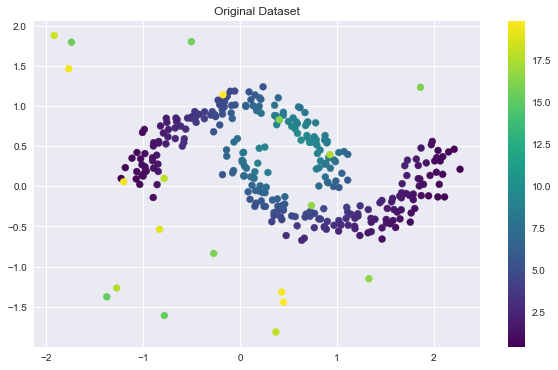

Dataset shape: (320, 2)
Target value range: 0.40 to 19.85


In [3]:
def create_imbalanced_dataset(n_samples=300, n_rare=20, random_state=42):
    """Create a simple 2D dataset with imbalanced target values"""
    # Set random seed
    np.random.seed(random_state)
    
    # Create two moons dataset
    X, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    
    # Generate target values based on x,y position
    y = 10 * np.exp(-((X[:, 0] - 0.5)**2 + (X[:, 1] - 0.5)**2))
    
    # Add some rare high values
    rare_points = np.random.uniform(low=-2, high=2, size=(n_rare, 2))
    rare_values = np.random.uniform(low=15, high=20, size=n_rare)
    
    X = np.vstack([X, rare_points])
    y = np.concatenate([y, rare_values])
    
    return X, y

# Create dataset
X, y = create_imbalanced_dataset()

# Visualize
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)
plt.title('Original Dataset')
plt.show()

print(f'Dataset shape: {X.shape}')
print(f'Target value range: {y.min():.2f} to {y.max():.2f}')

## Using SUS

Now let's apply the SUS method to our imbalanced dataset. We'll examine how it identifies rare samples and selects representatives from normal samples.

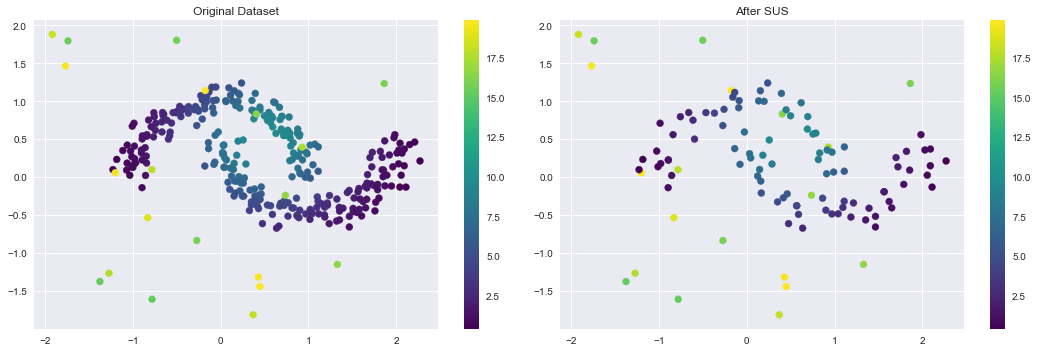

Original dataset size: 320
Resampled dataset size: 111


In [4]:
# Initialize and apply SUS
sus = SUS(k=7, blobtr=0.75, spreadtr=0.5)
X_resampled, y_resampled = sus.fit_resample(X, y)

# Visualize results
plt.figure(figsize=(15, 5))

# Original dataset
plt.subplot(1, 2, 1)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)
plt.title('Original Dataset')

# Resampled dataset
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, cmap='viridis')
plt.colorbar(scatter)
plt.title('After SUS')

plt.tight_layout()
plt.show()

print(f'Original dataset size: {len(X)}')
print(f'Resampled dataset size: {len(X_resampled)}')

## Examining SUS Components

Let's look at how SUS identifies rare samples and processes clusters.

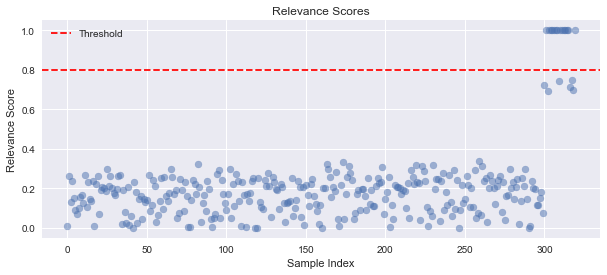

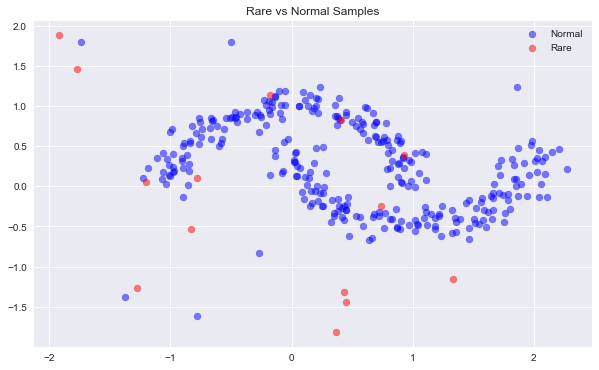

Rare samples: 14
Normal samples: 306


In [5]:
# Compute and visualize relevance scores
relevance = sus._compute_relevance(y)

plt.figure(figsize=(10, 4))
plt.scatter(range(len(y)), relevance, alpha=0.5)
plt.axhline(y=sus.relevance_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Relevance Scores')
plt.xlabel('Sample Index')
plt.ylabel('Relevance Score')
plt.legend()
plt.show()

# Visualize rare vs normal split
(X_rare, y_rare), (X_normal, y_normal) = sus._split_rare_normal(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(X_normal[:, 0], X_normal[:, 1], c='blue', label='Normal', alpha=0.5)
plt.scatter(X_rare[:, 0], X_rare[:, 1], c='red', label='Rare', alpha=0.5)
plt.title('Rare vs Normal Samples')
plt.legend()
plt.show()

print(f'Rare samples: {len(X_rare)}')
print(f'Normal samples: {len(X_normal)}')

## Using SUSiter

Now let's demonstrate the iterative version of SUS, which is especially useful for training neural networks.

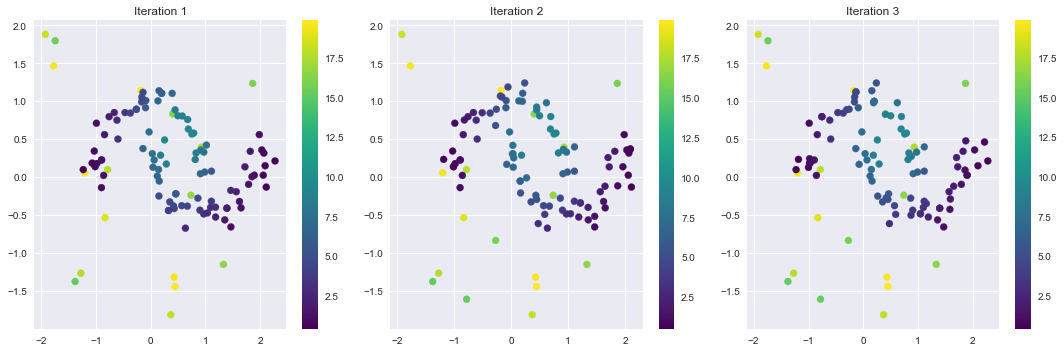

Note how each iteration maintains rare samples while varying normal samples


In [6]:
# Initialize SUSiter
susiter = SUSiter(k=7, blobtr=0.75, spreadtr=0.5, replacement_ratio=0.3)
susiter.fit(X, y)

# Get and visualize 3 different iterations
plt.figure(figsize=(15, 5))

for i in range(3):
    X_iter, y_iter = susiter.get_iteration_sample()
    
    plt.subplot(1, 3, i+1)
    scatter = plt.scatter(X_iter[:, 0], X_iter[:, 1], c=y_iter, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Iteration {i+1}')

plt.tight_layout()
plt.show()

print('Note how each iteration maintains rare samples while varying normal samples')

## Training Loop Example

Here's how you would use SUSiter in a training loop with a neural network:

In [7]:
# Example with a simple neural network (using sklearn for demonstration)
from sklearn.neural_network import MLPRegressor

# Initialize model and SUSiter
model = MLPRegressor(hidden_layer_sizes=(10, 5), max_iter=1)
susiter = SUSiter(k=7, blobtr=0.75, spreadtr=0.5, replacement_ratio=0.3)
susiter.fit(X, y)

# Training loop
n_epochs = 5
for epoch in range(n_epochs):
    # Get data for this iteration
    X_iter, y_iter = susiter.get_iteration_sample()
    
    # Train for one epoch
    model.partial_fit(X_iter, y_iter)
    
    print(f'Epoch {epoch+1}: training with {len(X_iter)} samples')

Epoch 1: training with 111 samples
Epoch 2: training with 111 samples
Epoch 3: training with 111 samples
Epoch 4: training with 111 samples
Epoch 5: training with 111 samples
